# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**

**20/07/2020 - E3 S15**


**Integrantes del grupo**:  

## Ejercicio 3

El objetivo de esta evaluación es resolver un problema de detección de noticias falsas (*Fake News*) usando herramientas de aprendizaje de máquinas. 

Para lograr una representación numérica de los textos utilizaremos la librería `spaCy` para procesamiento de lenguaje natural. 

**Instalaciones previas**  
Para la ejecución correcta de este notebook puede ser necesario ejecutar los siguientes comandos de instalación:

```python
!pip install spacy tqdm
!pip install -c pytorch torchtext
!python -m spacy download en_core_web_sm
```
**Obs:** Puede usar conda en vez de pip si maneja su librería con esta herramienta. 

Las librerías que se instalan son:
- spacy: ampliamente usada para procesamiento de lenguaje natural. Esta librería posee modelos estadísticos preentrenados como `en_core_web_sm` que será detallado posteriormente.
- tqdm: para mostrar barras de progreso en pantalla.
- torchtext: contiene en herramientas populares de procesamiento de lenguaje natural.

**Librerías**  
En la evaluación, **no** estará permitido usar librerías ni módulos diferentes a los declarados en la siguiente celda.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import spacy
import os
import numpy as np
import pickle as pk

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report,\
    confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe

'''
Puede utilizar esta extension si trabaja en colaboratory:
from google.colab import drive
drive.mount('/content/drive')
''';
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir(os.getcwd()+'/drive/My Drive/MA6202/E3')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Replicabilidad**  
A lo largo de todo el ejercicio llamaremos múltiples veces a la función `np.random.seed`, con la semilla fija en la variable `seed_=300`

In [2]:
seed_ = 300
np.random.seed(seed_)

**Uso de GPU**  
En este ejercicio se utilizarán modelos que requieren alto poder de computo por lo que se recomienda usar GPU. Recuerde que en **Colaboratory** tiene acceso gratuito a dicho recurso.  

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Preliminares

### Carga de datos


- Compruebe que la siguiente celda coincide con este output:

```
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6335 entries, 8476 to 4330
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 198.0+ KB
```

In [4]:
raw_data_path = 'https://raw.githubusercontent.com/NicoCaro/DataScienceLab/master/ejercicios/ejercicio%203/data/news.csv'
raw_df = pd.read_csv(raw_data_path, index_col=0)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6335 entries, 8476 to 4330
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 198.0+ KB


**Preprocesamiento**  
El conjunto de datos consta de 3 columnas:
- `title`: contiene el título de la noticia
- `text`: contiene el teto de la noticia
- `label`: contiene las etiquetas `REAL` y `FAKE` que indican si se trata de una noticia verdadera o falsa.

En la siguiente celda se incluye la columna `X` con una concatenación del título y el texto de las noticias, además de la columna `y` como una representación numérica de la columna `label`.

In [5]:
pro_df = raw_df.copy()
pro_df['y'] = (pro_df['label'] == 'FAKE').astype('int')
pro_df['X'] = pro_df['title'].str.cat(pro_df['text'], sep='. ')

# se eliminan las columnas innecesarias
pro_df = pro_df.reindex(columns=['X', 'y'])
display(pro_df.head())

,X,y
8476,You Can Smell Hillary’s Fear. Daniel Greenfiel...,1
10294,Watch The Exact Moment Paul Ryan Committed Pol...,1
3608,Kerry to go to Paris in gesture of sympathy. U...,0
10142,Bernie supporters on Twitter erupt in anger ag...,1
875,The Battle of New York: Why This Primary Matte...,0


### Procesamiento de texto
A modo de ejemplo se muestra el procesamiento que se busca aplicar a cada una de las observaciones de la columna `X`.

In [6]:
x_muestra, y_muestra = pro_df.iloc[3].values.T
print('Noticia falsa' if y_muestra else 'Noticia verdadera', '-' * 72,  sep='\n')
print(x_muestra[:501], '...')

Noticia falsa
------------------------------------------------------------------------
Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!'. — Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. 
— People For Bernie (@People4Bernie) November 9, 2016 If Dems didn't want a tight race they shouldn't have worked against Bernie. 
— Walker Bragman (@WalkerBragman) November 9, 2016 
New York Times columnist Paul Krugman, who was  ...


**Definición del modelo `spacy`**  
El modelo estadístico de `spacy` que usaremos en el ejercicio es `english_web_sm`, que consiste en un objeto basado en una red convolucional, preentrenada en un conjunto de datos llamado Ontowords y diseñada para resolver múltiples tareas de procesamiento de lenguaje natural, dento de sus métodos se encuentran rutinas de tokenización y lematización detalladas posteriormente.

Dentro de las funcionalidades que entrega este modelo, hay un subconjunto que no se utilizará en el ejercicio. Para ahorrar tiempo de cómputo, estas funcionalidades son deshabilitadas en el  el argumento `disable`.

**Obs:** Puede ser necesario ejecutar `python -m spacy download en_core_web_sm` para tener acceso a tal modelo de lenguaje.

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['entitry_ruler', 'textcat', 
                                            'entity_linker', 'ner', 'tagger'])
print(type(nlp))

<class 'spacy.lang.en.English'>


**Tokenización**  

Lo primero para analizar texto es separar el campo de texto en _tokens_. Un _token_ es un segmento significativo del texto. La entrada al tokenizer es un texto unicode, y la salida es un `spacy.tokens.doc.Doc`.


El proceso puede entenderse como:
1. Aplicar el método `str.split(' ')` que entrega una lista de `str`.
2. Verificar si cada uno de los elementos de la lista puede subdividirse:
    1. **Porque se trata de una regla de excepción.** Por ejemplo `don't` debería subdividirse en `do` y `n't`, mientras que `U.K.` no debe subdividirse.
    2. **Porque el elemento contiene prefijos, sufijos o [infijos](https://dle.rae.es/infijo).** Por ejemplo comillas, comas, puntos, etc...
    
Para más detalles ver la documentación de [spacy](https://spacy.io/usage/linguistic-features#tokenization).

Así al generar *tokens* en `x_muestra`, los 20 primeros son: 

In [8]:
spacy_doc = nlp(x_muestra)
[print(token) for token in spacy_doc[:20]];

Bernie
supporters
on
Twitter
erupt
in
anger
against
the
DNC
:
'
We
tried
to
warn
you
!
'
.


**Lematización**  
La [lematización](https://es.wikipedia.org/wiki/Lematizaci%C3%B3n) es el proceso de agrupar las formas flexionadas de una palabra (en plural, en femenino, conjugada, etc), para que puedan analizarse como un solo elemento, identificado por el **lema** de la palabra.

En procesamiento de lenguaje natural a lematización depende de la identificación correcta de la [categoría gramatical](https://es.wikipedia.org/wiki/Categor%C3%ADa_gramatical) (*part of speech*). Algunos ejemplos de categoría gramatical son sustantivo, adjetivo, verbo, advervio, etc...

En `spacy` accedemos al lema mediante el atributo `lemma_`. Así, para los 20 primeros *tokens*:

In [9]:
[print(token.lemma_) for token in spacy_doc[:20]];

Bernie
supporter
on
Twitter
erupt
in
anger
against
the
DNC
:
'
We
try
to
warn
you
!
'
.


**Stopwords**  
Los *tokens* generados pueden ser clasificados como [palabras vacías](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa) (*stop words*) que no tienen significado en si mismas. Algunos ejemplos son preposiciones, artículos, pronombres, etc... En procesamiento de lenguaje natural es común eliminarlas.

Para este ejercicio eliminaremos las *palabras vacías* mediante el atributo `is_stop`, además de los *token* que no sean alfanuméricos mediante el atributo `is_alpha`. 

In [10]:
[print(token) for token in spacy_doc[:20] if (not token.is_stop) and token.is_alpha];

Bernie
supporters
Twitter
erupt
anger
DNC
tried
warn


#### Pregunta 1
1. Defina la función `procesa_texto` que reciba como argumento un texto y un modelo de lenguaje `spacy`. La función `procesa_texto` debe entregar un texto con los lemas de cada *token*, eliminando las palabras vacías y los *token* que no sean alfanuméricos, usando el procedimiento recién presentado. El texto obtenido debe separar los lemas por espacios `' '`.
2. Aplique dicha función a la columna `X`, guardando sus resultados en la columna `pro_X`. Como modelo de lenguaje `spacy`, utilice el modelo instanciado anteriormente.  
    **Observaciones**:
    - Es usual que esta operación tome bastante tiempo por lo que recomendamos usar el método `progress_apply` de pandas que permite reportar el progreso de la operación mediante la librería `tqdm`. Para habilitar dicho método de la librería pandas debe primero llamar al método `tqdm.pandas`.
    - Puede ser útil guardar el resultado de esta operación en disco, dado el tiempo que toma repetir la operación. 

In [11]:
# 1
def procesa_texto(text,spacymodel):
  ''' Reduce un texto general a uno reducido con los lemas de cada token.
  '''
  spacy_doc = spacymodel(text)
  stringlist = [token.lemma_ for token in spacy_doc if (not token.is_stop) and token.is_alpha]

  return ' '.join(stringlist)

In [12]:
procesa_texto(x_muestra,nlp)

'Bernie supporter Twitter erupt anger DNC try warn Kaydee King November lesson tonight Dem loss Time Democrats start listen voter Stop run establishment candidate People Bernie November Dems want tight race work Bernie Walker Bragman November New York Times columnist Paul Krugman Hillary Clinton outspoken surrogate contentious Democratic primary blame Clinton poor performance Green Party candidate Jill Stein far receive negligible numb vote nationally say Stein Ralph Nader prevent Clinton victory account throw Krugman analysis face candidate issue responsibility Teachers Bernie November Ana Navarro Republican recently endorse Hillary Clinton sum preposterous nature presidential election tweet GOP nominate damn candidate lose Hillary Clinton Democrats nominate damn candidate lose Trump Ana Navarro November Popular leave wing Facebook page pro Sanders primary respond Trump surge simply post meme Sanders face text avoid Thanks DNC meme share time hour Posted Tuesday November Bernie Sander

In [13]:
# 2
tqdm.pandas()

In [14]:
# Se genera la columna de textos procesados 'pro_X'
pro_df['pro_X'] = pro_df.loc[:,'X'].progress_apply(lambda x : procesa_texto(x,nlp))

In [15]:
os.makedirs('data')

In [16]:
# Se guarda el df generado en un archivo .pkl
pro_df.to_pickle('./data/pro_df.pkl')

# Se carga el df del archivo .pkl previamente guardado
pro_df = pd.read_pickle(os.getcwd() + '/data/pro_df.pkl')

In [17]:
pro_df.head()

,X,y,pro_X
8476,You Can Smell Hillary’s Fear. Daniel Greenfiel...,1,Smell Hillary Fear Daniel Greenfield Shillman ...
10294,Watch The Exact Moment Paul Ryan Committed Pol...,1,Watch Exact Moment Paul Ryan Committed Politic...
3608,Kerry to go to Paris in gesture of sympathy. U...,0,Kerry Paris gesture sympathy Secretary State J...
10142,Bernie supporters on Twitter erupt in anger ag...,1,Bernie supporter Twitter erupt anger DNC try w...
875,The Battle of New York: Why This Primary Matte...,0,Battle New York Primary Matters primary day Ne...


3. Cuente el número de lemas en cada observación de la columna `pro_X` y compruebe que obtiene las siguientes estadísticas descriptivas:

```
count    6335.000000
mean      393.084294
std       409.950812
min         2.000000
25%       153.000000
50%       311.000000
75%       515.000000
max      8730.000000
Name: pro_X, dtype: float64
```
*Hint*: puede ser útil el método `pd.Series.str.count`.

In [18]:
# 3
pro_df.loc[:,'pro_X'].str.count(pat=' ').describe()

count    6335.000000
mean      392.084294
std       409.950812
min         1.000000
25%       152.000000
50%       310.000000
75%       514.000000
max      8729.000000
Name: pro_X, dtype: float64

4. Instancie `final_df` como una copia de `pro_df` a la que se le elimina la columna `'X'`. Luego aplique la eliminación de los duplicados `final_df`.   
- Compruebe que obtiene un total de 6,303 filas únicas en `final_df`.


In [19]:
# 4
final_df = pro_df.reindex(columns=['pro_X', 'y'], copy=True).drop_duplicates()
final_df

,pro_X,y
8476,Smell Hillary Fear Daniel Greenfield Shillman ...,1
10294,Watch Exact Moment Paul Ryan Committed Politic...,1
3608,Kerry Paris gesture sympathy Secretary State J...,0
10142,Bernie supporter Twitter erupt anger DNC try w...,1
875,Battle New York Primary Matters primary day Ne...,0
...,...,...
4490,State Department say find email Clinton specia...,0
8062,P PBS Stand Plutocratic Pentagon P PBS Stand P...,1
8622,Anti Trump Protesters Tools Oligarchy Informat...,1
4021,Ethiopia Obama seek progress peace security Ea...,0


### Definición de notación
De ahora en adelante denotamos por:
- ***Documento***: cada una de las noticias procesadas del conjunto de datos, es decir, cada una de las observaciones de la columna `'pro_X'`del DataFrame `final_df`.
- ***Corpus***: el conjunto de *documentos* del conjunto de datos, es decir, el conjunto de observaciones de la columna `'pro_X'` del DataFrame `final_df`.
- ***Vocabulario***: al conjunto de *tokens* presentes en el *corpus*.


### Definición de conjuntos del problema
Se separan las muestras en dos conjuntos:
- Conjunto de *entrenamiento union validación* (denotado por `*_full_train`), con el 80% de las observaciones
- Conjunto de *prueba* (denotado por `*_test`), con el 20% de las observaciones.

A su vez el conjunto de *entrenamiento union validación* de subdivide en:
- Conjunto de *entrenamiento* (denotado por `*_train`), con el 64% de las observaciones.
- Conjunto de *validación* (denotado por `*_val`), con el 16% de las observaciones

Para realizar esta subdivisión utilizamos dos veces la función `sklearn.model_selection.train_test_split`.

In [20]:
# define parametros de la division de conjuntos
proporcion_total_entrenamiento_prueba = 0.80
proporcion_entrenamiento_validacion = 0.80

# obtiene conjunto de prueba
X_full_train, X_test, y_full_train, y_test= train_test_split(
    final_df.pro_X, final_df.y, train_size=proporcion_total_entrenamiento_prueba, 
    random_state=seed_)

# obtiene conjunto de entrnamiento y validacion
X_train, X_val, y_train, y_val  = train_test_split(
    X_full_train, y_full_train, train_size=proporcion_entrenamiento_validacion, 
    random_state=seed_)

# guardar los conjuntos en formato csv
conjuntos_dir = 'conjuntos'
os.makedirs(conjuntos_dir, exist_ok=True)
guarda_csv = lambda X, y, filename: pd.DataFrame({
    'pro_X': X, 'y': y
}).to_csv(f'{conjuntos_dir}/{filename}.csv', index=None)
guarda_csv(X_train, y_train, 'entrenamiento')
guarda_csv(X_val, y_val, 'validacion')
guarda_csv(X_test, y_test, 'prueba')

## Modelos de aprendizaje de máquinas


### Modelos no paramétricos

#### Representación por conteo de ocurrencias.
Dado que se busca resolver un problema de clasificación de documentos, es necesario representar los documentos de forma numérica. A continuación usaremos la representación por conteo de apariciones de cada uno de los *tokens* presentes en el *vocabulario*.

Para realizar esta vectorización de documentos se utiliza la clase `sklearn.feature_extraction.text.CountVectorizer`. El método `fit_transform` de esta clase  recibe como argumento un `iterable` de *documentos*, extrae el *vocabulario* de dicho `iterable` y retorna la matriz de número de ocurrencias de cada *token* del *vocabulario*, en cada uno de los documentos del `iterable`. En otras palabras, definiendo $\text{tf}(t_i, \mathbf{d}_j)$ como el número de apariciones del *token* $t_i$ en el *documento* $\mathbf{d}_j$, `~CountVectorizer.fit_transform` retorna la matriz $\mathbf{C}$ definida por:
$$\big(c_{i, j}\big) = \text{tf}(t_j, \mathbf{d}_i)$$

#### Naive Bayes

Se emplea el algoritmo de *Naive Bayes* como base de referencia para los modelos más complejos empleados posteriormente. Específicamente, se utiliza una instancia de la clase `sklearn.naive_bayes.MultinomialNB` que está diseñado para trabajar con las características del tipo conteo. 



##### Pregunta 2
1. Instancie `nb_pipe` como un objeto de la clase `sklearn.pipeline.Pipeline` con los componentes:
    - `~CountVectorizer` inicializado con `max_features=20000` los demás parámetros por defecto.
    - `~MultinomialNB` inicializado con los parámetros por defecto.  
    
   Posteriormente, ajuste `nb_pipe` en el conjunto de *entrenamiento union validación* y guarde el modelo resultante en la carpeta `modelos/nb_pipe.pk` como un archivo `pickle`. 

In [21]:
# 1
# Se crea la pipeline
nb_pipe = Pipeline(steps=[('vectorizacion',CountVectorizer(max_features=20000)),
                          ('naive_bayes', MultinomialNB())] 
                   )

In [22]:
# Se realiza el ajuste sobre entrenamiento 'union' validación, 
# es decir, en X_full_train, y_full_train
nb_pipe.fit(X_full_train,y_full_train)

Pipeline(memory=None,
         steps=[('vectorizacion',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=20000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('naive_bayes',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [23]:
# Se guarda el modelo en un archivo .pk
os.makedirs(os.getcwd() + f'/modelos/', exist_ok=True)

with open(os.getcwd() + '/modelos/nb_pipe.pk', 'wb') as handler:
  pk.dump(nb_pipe, handler)

2. Defina la función `evalua_sklearn`  que reciba como argumentos:
    - `y_true`: np.array de una dimensión, conteniendo las etiquetas de cada una de las observaciones 
    - `y_pred`: np.array, con las etiquetas predichas por algún modelo de clasificación
    - `nombre_clasificador`: str, define el nombre de la carpeta donde los resultados son guardados. 
    
  Esta función debe:
    - Imprimir en pantalla los resultados de clasificación, mediante `sklearn.metrics.classification_report` con 4 dígitos de precisión. Además debe guardar dichos resultadoes  en la ruta `f'resultados/{nombre_clasificador}/reporte_clasificacion.txt'`.
    - Generar un gráfico con la *matriz de confusión* mediante el uso de `sklearn.metrics.confusion_matrix` y `seaborn.heatmap`. Además debe guardar dicho gráfico en la ruta `f'resultados/{nombre_clasificador}/mc.pdf'`.
    
  Pruebe esta función con la predicción de `nb_pipe` sobre el conjunto de *prueba*, usando `nombre_clasificador='nb_pipe'`.

In [24]:
# 2
def evalua_sklearn(y_true,y_pred,nombre_clasificador):

  # Se crea el directorio con resultados en caso de no existir
  os.makedirs(os.getcwd() + f'/resultados/{nombre_clasificador}', exist_ok=True)
  
  # Imprime en pantalla los resultados de la clasificación 
  print(classification_report(y_true,y_pred,digits=4))

  # Se crea un archivo y se guardan los resultados
  with open(os.getcwd() + f'/resultados/{nombre_clasificador}/reporte_clasificacion.txt', 'w+') as f:
    print(classification_report(y_true,y_pred,digits=4), file=f)
  
  # Se crea y guarda el gráfico con la matríz de confusión 
  sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred))
  plt.savefig(f'resultados/{nombre_clasificador}/mc.pdf', 
              format='pdf', bbox_inches='tight')

              precision    recall  f1-score   support

           0     0.8895    0.9217    0.9053       664
           1     0.9092    0.8727    0.8906       597

    accuracy                         0.8985      1261
   macro avg     0.8994    0.8972    0.8980      1261
weighted avg     0.8989    0.8985    0.8984      1261



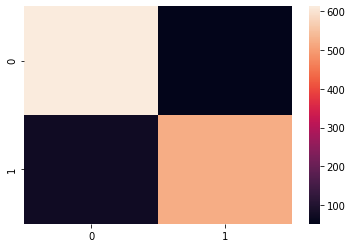

In [25]:
# Se evalua el desempeño del modelo en el conjunto de prueba
y_test_pred_nb = nb_pipe.predict(X_test)
evalua_sklearn(y_test, y_test_pred_nb,'nb_pipe')

- Compruebe que obtiene un *accuracy* y un promedio ponderado de *f1-score* superiores a .89.  

In [26]:
f1_scores = np.array([0.9053,0.8906, 0.8985, 0.8980, 0.8984]) # aún no se como extraer del .txt
print('accuracy_score:', accuracy_score(y_true=y_test,y_pred=y_test_pred_nb))
print('mean f1_score:', np.mean(f1_scores))

accuracy_score: 0.8984932593180016
mean f1_score: 0.8981600000000001


#### Representación Tf-idf

Para esta sección y la posterior se emplea la clase `sklearn.feature_extraction.text.TfidfVectorizer`. 

Para comprender el algoritmo ***tf-idf*** (*term frequency - inverse document frequency*) necesitamos definir 3 de sus componentes:
- $\text{tf}(t_j, \mathbf{d}_i)$ que representa el número de apariciones del *token* $t_j$ en el *documento* $\mathbf{d}_i$.

- $\text{df}(t_j)$ que representa el número de documentos en que aparece el *token* $t_j$.
- $\text{idf}(t_j)$ que representa el inverso de la frecuencia del *token* $t_j$ en los *documentos* del *corpus*. En el caso particular del objeto `~.TfidfVectorizer` empleado, denotando por $n$ al numero de documentos del *corpus*, se usa una versión suavizada de la función $\text{idf}$. Esto es: 

$$
\text{idf}(t_j) = \log(\frac{1 + n}{1 + \text{df}(t_j)}) + 1
$$


Con dichos componentes, podemos definir a la representación vectorial del documento $\mathbf{d}_i$ mediante el vector $\textbf{tf-idf}(\mathbf{d}_i)$, cuyas coordenadas se calculan de la siguiente manera:

$$
\left(\textbf{tf-idf}(\mathbf{d}_i)_i\right) = \text{tf}(t_j, \mathbf{d}_i) \times \text{idf}(t_j)
$$


Así la salida del objeto `~.TfidfVectorizer` es la matriz de la concatenación por filas, de los vectores $\textbf{tf-idf}(\mathbf{d}_i)$ normalizados según la norma euclidiana, es decir, la matriz $\mathbf{X}$, definida por:


$$
\left( x_{i,j} \right) = \frac{\text{tf}(t_j, \mathbf{d}_i) \times \text{idf}(t_j)}{{||\textbf{tf-idf}(\mathbf{d}_i)||}_2} 
$$



donde ${||\cdot||}_2$ representa la norma euclidiana. En consecuencia se logra una representación vectorial sobre la esfera unitaria de la norma ${||\cdot||}_2$.

Una interpretación posible de esta representación vectorial es que cada *token* $t_j$ tiene mayor importancia en el documento $\mathbf{d}_i$:

- En la medida en que esta aparezca más veces en el documento
- En la medida en que esta aparezca menos veces en los demás documentos del corpus

#### Maquinas de soporte vectorial (SVM)

Se emplea el algoritmo de máquinas de soporte vectorial (*Support Vector Machines - SVM*) sobre la representación vectorial *tf-idf*. La clase utilizada para generar este modelo es `sklearn.svm.SVC`.



##### Pregunta 3
1. Instancie `svm_pipe` como un objeto de la clase `sklearn.pipeline.Pipeline` con los componentes:
    - `~.TfidfVectorizer` inicializado con `max_features=20000` los demás parámetros por defecto.
    - `~.SVC` inicializado con el kernel RBF y los parámetros por defecto.  
    
   Posteriormente, ajuste `svm_pipe` en el conjunto de *entrenamiento union validación* y guarde el modelo resultante en la carpeta `modelos/svm_pipe.pk` como un archivo `pickle`. Finalmente, reporte el desempeño del clasificador mediante `evalua_sklearn` con la predicción de `svm_pipe` sobre el conjunto de *prueba*, usando `nombre_clasificador='svm_pipe'`.

In [27]:
# 1
# Se crea la pipeline
svm_pipe = Pipeline(steps=[('vector Tfidf', TfidfVectorizer(max_features=20000)),
                           ('svc', SVC())]
                    )

In [28]:
# Se ajusta el modelo al conjunto de entrenamiento union validación, i.e.,
# a X_full_train e y_full_train
svm_pipe.fit(X_full_train,y_full_train)

# Se guarda el modelo en un archivo .pk
os.makedirs(os.getcwd() + f'/modelos/', exist_ok=True)

with open(os.getcwd() + '/modelos/svm_pipe.pk', 'wb') as handler:
  pk.dump(svm_pipe, handler)

              precision    recall  f1-score   support

           0     0.9507    0.9006    0.9250       664
           1     0.8956    0.9481    0.9211       597

    accuracy                         0.9231      1261
   macro avg     0.9231    0.9243    0.9230      1261
weighted avg     0.9246    0.9231    0.9231      1261



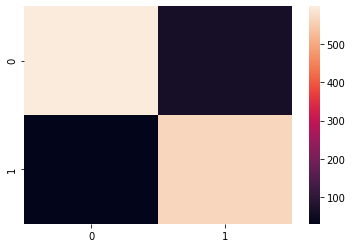

In [29]:
# Se evalua el desempeño del modelo en el conjunto de test
y_test_pred_svm = svm_pipe.predict(X_test)
evalua_sklearn(y_test, y_test_pred_svm,'svm_pipe')

Las máquinas de soporte vectorial son algoritmos que pueden ser muy sensibles a los hiperparámetros. Por esta razón es útil emplear un esquema de validación cruzada. A continuación se implementa un esquema de validación cruzada simple, que explora sólo diferentes kernels y coeficientes de regularización.
2. Instancie `svm_grid` como un objeto de la clase `sklearn.model_selection.GridSearchCV`con los parámetros:
    - `n_jobs=-1` para usar todos los núcleos disponibles
    - `param_grid` definido de tal forma que le permita probar las combinaciones de los siguientes hiperparámetros de `~SVC`:
        - `kernel` en {`'lineal'`, `'rbf'`}
        - `C` en {`.01`, `.1`, `1`, `10`, `100`}

    - `cv=3` para generar un esquema de validación cruzada estratificada con 3 *fold*.
    - `verbose=1` para reportar el progreso del ajuste en pantalla
    
  Los demás parámetros quedan con sus valores por defecto.  
  
  Ajuste `grid_search_svm` usando `svm_pipe` sobre el conjunto *entrenamiento union validación* y guarde el modelo resultante en la carpeta `modelos/svm_grid.pk` como un archivo `pickle`. Luego reporte el desempeño del clasificador mediante `evalua_sklearn` con la predicción de `svm_grid` sobre el conjunto de *prueba*, usando `nombre_clasificador='svm_grid'`.  
  
  **Obs**: Evite fuga de información al combinar ``svm_pipe`` con `grid_search_svm`.

  Finalmente, en ruta `resultados/svm_grid/mejores_parametros.txt` guarde los mejores parámetros obtenidos en `svm_grid`.

In [30]:
# no olvide fijar la semilla 
np.random.seed(seed_)

In [31]:
# Se genera la grilla de parámetros
grid = [{'svc__kernel': ['lineal'],
         'svc__C': [0.01, 0.1, 1, 10, 100]},
        {'svc__kernel': ['rbf'],
         'svc__C': [0.01, 0.1, 1, 10, 100]}
        ]

# Se comienza el modelo de búsqueda
svm_grid = GridSearchCV(estimator=svm_pipe, param_grid=grid, n_jobs=-1, cv=3, verbose=1) 

In [32]:
# Se ajusta el modelo al conjunto de entrenamiento union validación, i.e.,
# a X_full_train e y_full_train
svm_grid.fit(X_full_train, y_full_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vector Tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=20000,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

In [33]:
# Se guarda el modelo en un archivo .pk
os.makedirs(os.getcwd() + f'/modelos/', exist_ok=True)

with open(os.getcwd() + '/modelos/svm_grid.pk', 'wb') as handler:
  pk.dump(svm_grid, handler)

              precision    recall  f1-score   support

           0     0.9528    0.9111    0.9315       664
           1     0.9058    0.9497    0.9272       597

    accuracy                         0.9294      1261
   macro avg     0.9293    0.9304    0.9294      1261
weighted avg     0.9305    0.9294    0.9295      1261



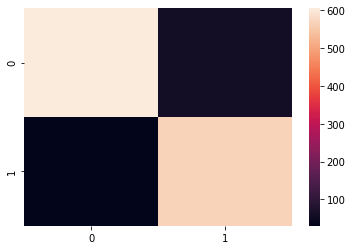

In [34]:
# Se evalua el desempeño del modelo en el conjunto de test
y_test_pred_svm_grid = svm_grid.predict(X_test)
evalua_sklearn(y_test, y_test_pred_svm_grid,'svm_grid')

In [35]:
# Se recupera el mejor modelo obtenido de la búsqueda
svm_grid_best = svm_grid.best_estimator_

# Se guardan los mejores parametros en un archivo .txt
with open(os.getcwd() + f'/resultados/svm_grid/mejores_parametros.txt', 'w+') as f:
  print(svm_grid_best.get_params(),file=f)

### Modelos paramétricos

En lo que sigue del ejercicio se construirá una red neuronal recurrente (*RNN*). Para ello se usará principalmente la librería `torchtext` que provee una serie de herramientas que facilitan el manejo de texto para redes neuronales.

#### Representación vectorial densa

En las representaciones vectoriales anteriores, cada *token* del *vocabulario* constituye una dimension del espacio, es decir, hay tantas dimensiones en el espacio vectorial de representación como *tokens* en el *vocabulario*.

Hay una desventaja enorme en esta representación, además de la cantidad enorme de dimensiones que genera. Esta es que básicamente trata todos los *token* como entidades independientes sin relación entre sí. Lo que se busca en una representación densa es alguna noción de similitud entre las palabras.

Por ejemplo, supoga que se construye un modelo de lenguaje y que hemos visto las oraciones:

- El matemático corrió a la tienda.
- El físico corrió a la tienda.
- El matemático resolvió un problema abierto.

en el conjunto de *entrenamiento*. Ahora supongamos que obtenemos una nueva oración no presente en el conjunto de *entrenamiento*:

- El físico resolvió un problema abierto.

Si bien el modelo de lenguaje puede funcionar bien en esta oración, sería mejor si se pudiera utilizar los siguientes aspectos:

- Se ha observado matemático y físico en el mismo papel en una oración. De alguna manera tienen una relación semántica.
- Se ha observado al matemático en el rol del físico en una oración análoga a esta nueva oración.

Así, se podría inferir que el físico en realidad encaja bien en la nueva oración. Esto esconde una noción de similitud: queremos decir similitud semántica, no simplemente tener representaciones ortográficas similares. Este ejemplo, por supuesto, se basa en una suposición lingüística fundamental: que las palabras que aparecen en contextos similares están relacionadas semánticamente entre sí. Esto se llama hipótesis ***distribucional***.

Sobre dicha hipotesis se basa la construcción de modelos de procesamiento de lenguaje natural llamado ***word embeddings*** que se utilizan a continuación.

<center>Explicación adaptada de <a href="https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html">Word Embedding: Encoding Lexical Semantics - Pytorch</a></center> 




##### Pregunta 4 
La forma de cargar datos en formato csv que provee `torchtext`, es mediante los objetos `torchtext.data.dataset.TabularDataset`. A direfencia de `pandas.read_csv`, donde la función puede inferir el tipo de dato de cada columna, `~.TabularDataset` necesita que dichos tipos de dato sean declarados, mediante el objeto `torchtext.data.Field`.

1. Instancie `train_td`, `val_td` y `test_td` mediante el método `~.TabularDataset.splits` que le permita cargar textos de los archivos `conjuntos/*.csv` respectivos. Para ello tendrá que instanciar dos objetos de la clase `~.Field` que definan el tipo de dato para cada columna:

- La columna `y`: declarada mediante el objeto `etiqueta_fd` como instancia de `~.Field`, con parametros `sequential=False, use_vocab=False, batch_first=True, dtype=torch.float` y los demás por defecto.
- La columna `pro_X`:  declarada mediante el objeto `documento_fd`, como instancia de `~.Field`, con parámetros `include_lengths=True, batch_first=True` y los demás por defecto. El primer parámetro (`include_lengths=True`) implica que cada *documento* cargado de la columna se entregará en forma de tupla, donde además de la secuencia de *tokens* de aquel *documento*, se adjuntará el largo de la secuencia o número de tokens contenidos en este.

**Obs**: Tendrá que inferir los parámetros con los cuales emplear el método `~.splits()`.

In [36]:
etiqueta_fd=Field(sequential=False,use_vocab=False,batch_first=True,dtype=torch.float)
documento_fd=Field(include_lengths=True,batch_first=True)


train_td, val_td, test_td = TabularDataset.splits(
    path=os.getcwd() + '/conjuntos/', train='entrenamiento.csv',
    validation='validacion.csv', test='prueba.csv', format='csv',
    fields=[('pro_X', documento_fd), ('etiqueta', etiqueta_fd)], skip_header=True)

`torchtext` también provee objetos que permiten iterar sobre un objeto de tipo `~.TabularDataset`. En particular, en el procesamiento de texto es beneficioso generar *batches* de secuencias que tengan largo similar, para ahorrar tiempo de escritura, ya que dichos *batches* al tener forma tensorial, deben ser completados por ceros (*padding*). Así por ejemplo, las secuencias:
```
[ [4, 16, 3, 8],
  [5, 2],
  [6, 6, 7, 9, 2] ]
```
deben ser transformadas a:
```
[ [4, 16, 3, 8, 0],
  [5, 2, 0, 0, 0],
  [6, 6, 7, 8, 2] ]
```

Mediante la clase ` torchtext.data.BucketIterator`, es posible iterar sobre instancias de `~.TabularDataset`, de manera que se minimiza la cantidad de *padding* y al mismo tiempo se mantiene un orden aleatorio de los datos.

2.  Instancie *iterators* de cada uno de los `~.TabularDataset` instanciados, mediante `~.BucketIterator.splits` con los parámetros `batch_size=32, sort_key=lambda x: len(x.pro_X),
device=device, sort=True, sort_within_batch=True`.


In [37]:
train_iter, val_iter, test_iter = BucketIterator.splits(
    (train_td, val_td, test_td), batch_sizes=(32, 32, 32),
    sort_key=lambda x: len(x.pro_X), device=device,sort=True, sort_within_batch=True)

3. Obtenga la representación vectorial del vocabulario con el *word embedding* GloVe entrenado en [Wikipedia 2014 + GigaWord 5](https://nlp.stanford.edu/projects/glove/). Para ello:
- Instancie el objeto `glove` como una instancia de la clase `torchtext.vocab.GloVe` con los parámetros`name="6B", dim=300`.
- Ejecute el método `build_vocab` del objeto `documento_fd` con `max_size=20000` y los demás parámetros que correspondan   
  Compruebe posteiormente que al llamar a `documento_fd.vocab.vectors.shape` obtiene las dimensiones `(20002,300)`

In [38]:
glove= GloVe(name='6B', dim=300)

documento_fd.build_vocab(train_td,max_size=20000,vectors=glove)

.vector_cache/glove.6B.zip: 862MB [06:31, 2.20MB/s]                           
100%|█████████▉| 399188/400000 [00:41<00:00, 9706.21it/s]

In [39]:
documento_fd.vocab.vectors.shape

torch.Size([20002, 300])

In [40]:
len(documento_fd.vocab.itos)

20002

#### LSTM 
Finalmete se implementa una LSTM bidireccional. La estructura de la red LSTM ya fue revisada en el material del curso, sin embargo, no se estudió su variante bidireccional. Esta denominación implica que la secuencia de tokens presente en cada texto es procesada desde el primer token hasta el último en una LSTM y desde el úĺtimo hasta el primero en otra LSTM, tal como lo ilustra la siguiente imagen.

<center> <img src="http://colah.github.io/posts/2015-09-NN-Types-FP/img/RNN-bidirectional.png" align="middle"> </center>
<center> Fuente: <a href="http://colah.github.io/posts/2015-09-NN-Types-FP/"> Colah's Blog </a></center>

Por consistencia con la imagen, supongamos que la LSTM bidireccional recibe un documento compuesto por la secuencia de tokens $x_0, \ldots, x_u$, de largo $i+1$. Sean $\text{LSTM}$ la RNN que recibe los inputs desde $0$ hasta $i$ y $\text{LSTM}'$ la RNN que los recibe desde $i$ hasta $0$. A cada input de la secuencia, $x_j$, corresponde un *output*, $y_j$ que consiste en la concatenación $\left(A(S_j, x_j),A'(S'_{i-j}, x_j)\right)$. Lo que debe ser considerado como la salida final de la LSTM bidireccional es la primera mitad de $y_i$ y la segunda mitad de $y_0$ pues corresponden a $A(S_i, x_i)$ y $A'(S'_i, x_0)$ respectivamente. Observe que este es output se asocia a la secuencia completa.

La LSTM bi-direccional que se implementa está diseñada para usar un *word embedding* fijo, como el que fue calculado en la sección anterior.

La estructura de la red es la siguiente:
- *Word embedding* pre-entrenado (no deben calcularse gradientes en esta sección de la red), implementado con la clase `torch.nn.Embedding`.
- LSTM bidireccional, tomando como salida la concatenación recién explicada e implementada con la clase `torch.nn.LSTM` con los parámetros `batch_first=True` y `bidirectional=True`. 
- Dropout con probabilidad .5
- Capa totalmente conectada con salida de tamaño 1 y función de activación sigmoide.

Dado que `~.BucketIterator` entrega un tensor con *paddings* de cero, es necesario transformar el input de `~.LSTM`, de tal forma que esta no procese los ceros del tensor de entrada. Por esta razón al pasar del output de `~.Embedding`, al input de `~.LSTM`, es necesario emplear la función `torch.nn.utils.rnn.pack_padded_sequence` que permite transformar una secuencia con *paddings* de 0, en una secuencia que los oculta. Dicha función es capaz de transformar un input de la forma:
```
seq = torch.tensor([[4,5,6], [1,2,0], [3,0,0]])
lens = [3, 2, 1]
packed = pack_padded_sequence(seq, lens, batch_first=True, enforce_sorted=True)
```
donde el objeto `packed` tendrá la forma:
```
PackedSequence(data=tensor([4, 1, 3, 5, 2, 6]), batch_sizes=tensor([3, 2, 1]), sorted_indices=None, unsorted_indices=None)
```
y estará listo para ser procesado como entrada de `~.LSTM`.

Sin embargo, el empleo de aquella función, obliga a usar su función inversa, `torch.nn.utils.rnn.pad_packed_sequence`, sobre la salida de `~.LSTM` y así que pasar de un objeto `PackedSequence` a su formato tensorial con *padding* de 0. En consecuencia al emplear:
```
lstm = nn.LSTM(...)
packed_output, _ = lstm(packed)
seq_unpacked, lens_unpacked = pad_packed_sequence(packed, batch_first=True)
``` 
Esto permitirá encontrar el output de la LSTM bidireccional en el tensor `seq_unpacked` de tamaño $B \times T \times C$, donde $B$ representa el tamaño del *batch*, $T$ el largo de la secuencia más larga del *batch* y $C$ el tamaño de la dimension del espacio de carácteristicas de la salida de `~.LSTM`. 


##### Pregunta 5

1. Defina la clase `Glove6B300BiLSTM` heredando de `torch.nn.Module` y definiendo los métodos:
- `__init__`: recibe como parametros `hidden_size`, que regula el parámetro homónimo de `torch.nn.LSTM`; y `text_field` que apunta al `torchtext.data.Field` que ya contiene la representación vectorial densa del *vocabulario* que es utilizado en la capa del *word embedding*.  
- `forward`: recibe como argumentos `text` y `text_len` que corresponden a los objetos que entrega `BucketIterator`.  
Haga uso de las funciones `~.pack_padded_sequence` con parámetros `batch_first=True, enforce_sorted=True` y `~.pad_packed_sequence`, con parámetro `batch_first=True`. Sea ciudadoso en la selección de los segmentos del tensor de salida de `~.pad_packed_sequence` que deben ser considerados para las capas posteriores.   

*Hint*: note que para construir el output de la $\text{LSTM}$ bidireccional, deberá seleccionar segmentos de un vector de salida y concatenarlos de manera conveniente. Para ello le será de ayuda la variable `text_len`.

  
Instancie `modelo` como objeto de la clase `Glove6B300BiLSTM` con `hidden_size=128` y `text_field=documento_fd`. Recuerde instanciarlo en el espacio de memoria adecuado mediante el método `to(device)`.

In [82]:
class Glove6B300BiLSTM(nn.Module):
  def __init__(self, hidden_size, text_field):
    super().__init__()

    # Embedding
    self.w_embedding = nn.Embedding.from_pretrained(text_field.vocab.vectors)
    self.w_embedding.weight.requires_grad = False

    #lstm
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=self.w_embedding.embedding_dim,
                        hidden_size=self.hidden_size,
                        batch_first=True,
                        bidirectional=True)

    # Dropout
    self.dropout = nn.Dropout(0.5)

    #sigmoide
    self.fc = nn.Linear(self.hidden_size*2,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, text, len_text):
    embedding = self.w_embedding(text)
    pack = pack_padded_sequence(embedding, len_text, batch_first=True, enforce_sorted=True)
    outputs, _ = self.lstm(pack)
    seq_pad , lens_pad = pad_packed_sequence(outputs,batch_first=True)
    versa = seq_pad[:,-1,:self.hidden_size]
    reversa = seq_pad[:,0,self.hidden_size:]
    x = torch.cat((versa,reversa), dim=1)  
    x_2 = self.fc(self.dropout(x))
    return self.sigmoid(x_2).view(-1)

In [83]:
modelo = Glove6B300BiLSTM(hidden_size = 128, text_field = documento_fd)

2. Implemente el ciclo de entrenamiento de la red `Glove6B300BiLSTM`. Para ello use:
- Entropía cruzada binaria como funcion de costo - `torch.nn.BCELoss()`
- Adam cómo algoritmo de optimización, con `lr=2e-4`
- 10 epocas de entrenamiento
- Los `BucketIterator` definidos en la pregunta anterior para recorrer los conjuntos de entrenamiento y validación.
- Guarde en una lista el historico de valores de la función de costo en el conjunto de entrenamiento y de validación
- Al final de cada época guarde el modelo mediante `guardar_modelo` en la ruta `modelos/Glove6B300BiLSTM.h5`, si es que la función de costo sobre el conjunto de validación es menor que la menor función de costo sobre el conjunto de validación observada en épocas anteriores. 

Al finalizar el entrenamiento, muestre en pantalla un gráfico con el historico de la función de costo en el conjunto de entrenamiento y en el de validación y guardelo en `resultados/Glove6B300BiLSTM/costo_historico.pdf`.


In [84]:
def accuracy_tensor(y_true,y_pred):
  vector_pred = y_pred.clone()
  vector_pred = vector_pred.cpu().detach().numpy()
  vector_pred[vector_pred>0.5]=1
  vector_pred[vector_pred<0.5]=0
  vector_pred = vector_pred.astype(int)

  vector_real = y_true.clone()
  vector_real = vector_real.cpu().detach().numpy().astype(int)
  return accuracy_score(vector_real,vector_pred)

In [86]:
criterio = nn.BCELoss()
opt = optim.Adam(modelo.parameters(),lr=2e-4)
epochs = 10
counter = 0
costos_train = []
costos_val = []
modelo = modelo.to(device)
criterio = criterio.to(device)

modelo.train()

for ep in range(epochs):
  for batch in train_iter:
    text = batch.pro_X[0]
    len_text = batch.pro_X[1]
    etiqueta = batch.etiqueta
    opt.zero_grad()

    predictions = modelo.forward(text=text,len_text=len_text)

    loss = criterio(predictions, etiqueta)
    loss.backward()
            
    nn.utils.clip_grad_norm_(modelo.parameters(), 5)

    opt.step()
    counter += 1
    if counter % 20 == 0:
      val_loss = []
      val_acc = []
      for val in val_iter:
        text_val = val.pro_X[0]
        len_text_val = val.pro_X[1]
        etiqueta_val = val.etiqueta

        output_val = modelo.forward(text_val, len_text_val)
        vl = criterio(etiqueta_val,output_val.data).cpu().numpy()+0
        accur = accuracy_tensor(etiqueta_val,output_val)
        
        val_loss.append(vl)
        val_acc.append(accur)

      print("Epoch: {}/{}...".format(ep+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.4f}...".format(loss.item()),
          "Val Loss: {:.4f}...".format(np.mean(val_loss)),
          "Acurracy medio: {:.4f}".format(np.mean(val_acc)))
      print('-'*30)
      print('-'*30,'\n')
    
  
  media_loss=[]
  for train in train_iter:
    pred_train = modelo.forward(train.pro_X[0],train.pro_X[1])
    meanloss = criterio(train.etiqueta,pred_train.data).cpu().numpy() +0
    media_loss.append(meanloss)

  costos_train.append(np.mean(media_loss))

  media_val_loss=[]
  for val in val_iter:
    pred_val = modelo.forward(val.pro_X[0],val.pro_X[1])
    meanloss_val = criterio(val.etiqueta,pred_val.data).cpu().numpy() +0
    media_val_loss.append(meanloss_val)
  if costos_val == []:
    with open(os.getcwd() + '/modelos/Glove6B300BiLSTM.pk', 'wb') as handler:
      pk.dump(modelo, handler)
    
    costos_val.append(np.mean(media_val_loss))
  else:
    if np.mean(media_val_loss) < np.min(costos_val):
      with open(os.getcwd() + '/modelos/Glove6B300BiLSTM.pk', 'wb') as handler:
        pk.dump(modelo, handler)
    costos_val.append(np.mean(media_val_loss))


Epoch: 1/10... Step: 20... Loss: 0.6914... Val Loss: 49.6391... Acurracy medio: 0.6179
------------------------------
------------------------------ 

Epoch: 1/10... Step: 40... Loss: 0.6815... Val Loss: 49.7564... Acurracy medio: 0.5604
------------------------------
------------------------------ 

Epoch: 1/10... Step: 60... Loss: 0.6827... Val Loss: 49.4396... Acurracy medio: 0.5701
------------------------------
------------------------------ 

Epoch: 1/10... Step: 80... Loss: 0.6709... Val Loss: 48.0204... Acurracy medio: 0.7759
------------------------------
------------------------------ 

Epoch: 1/10... Step: 100... Loss: 0.5213... Val Loss: 43.5936... Acurracy medio: 0.6209
------------------------------
------------------------------ 

Epoch: 1/10... Step: 120... Loss: 0.6983... Val Loss: 40.1211... Acurracy medio: 0.7434
------------------------------
------------------------------ 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch: 2/10... Step: 140... Loss: 0.6797... Val Loss: 39.4124... Acurracy medio: 0.7671
------------------------------
------------------------------ 

Epoch: 2/10... Step: 160... Loss: 0.4933... Val Loss: 44.1537... Acurracy medio: 0.5704
------------------------------
------------------------------ 

Epoch: 2/10... Step: 180... Loss: 0.6633... Val Loss: 40.1775... Acurracy medio: 0.7369
------------------------------
------------------------------ 

Epoch: 2/10... Step: 200... Loss: 0.4645... Val Loss: 35.5410... Acurracy medio: 0.8012
------------------------------
------------------------------ 

Epoch: 2/10... Step: 220... Loss: 0.5322... Val Loss: 33.0197... Acurracy medio: 0.7417
------------------------------
------------------------------ 

Epoch: 2/10... Step: 240... Loss: 0.3825... Val Loss: 31.0990... Acurracy medio: 0.7864
------------------------------
------------------------------ 

Epoch: 3/10... Step: 260... Loss: 0.3681... Val Loss: 29.1462... Acurracy medio: 0.8051


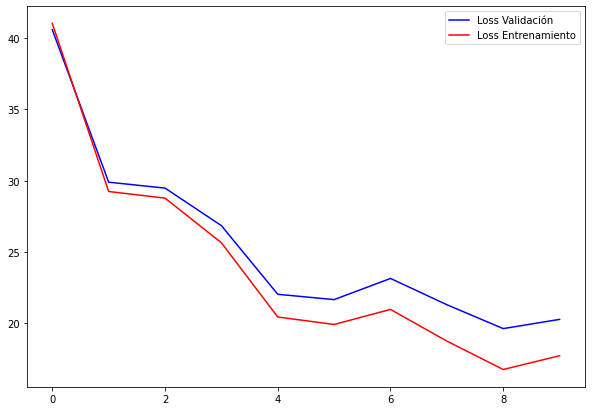

In [87]:
plt.figure(figsize=(10,7))
plt.plot(costos_val, color = 'b', label='Loss Validación')
plt.plot(costos_train, color = 'r', label='Loss Entrenamiento')
plt.legend()

3. Obtenga la predicción de `modelo` sobre el conjunto de prueba y reporte el desempeño del clasificador mediante `evalua_sklearn` con la predicción de `modelo` sobre el conjunto de *prueba*, usando `nombre_clasificador='Glove6B300BiLSTM'`.

In [89]:
modelo_besto = pd.read_pickle(os.getcwd() + '/modelos/Glove6B300BiLSTM.pk')

In [145]:
news =[]
orden =[]
labels =[]

for test in test_iter:
  news.append(test.pro_X[0])
  orden.append(test.pro_X[1])
  labels.append(test.etiqueta)

In [146]:
%%capture
preds = []
labs =[]

for i in range(40):
  prediccion = modelo_besto.forward(news[i],orden[i]).cpu().detach().numpy()
  prediccion[prediccion>0.5]=1
  prediccion[prediccion<0.5]=0
  preds.append(prediccion.astype(int))

  tick = labels[i].cpu().detach().numpy().astype(int)
  labs.append(tick)

In [150]:
y_pred=[]
y_true=[]
for i in range(40):
  y_pred.extend(preds[i])
  y_true.extend(labs[i])

              precision    recall  f1-score   support

           0     0.8636    0.8675    0.8655       664
           1     0.8519    0.8476    0.8497       597

    accuracy                         0.8580      1261
   macro avg     0.8577    0.8575    0.8576      1261
weighted avg     0.8580    0.8580    0.8580      1261



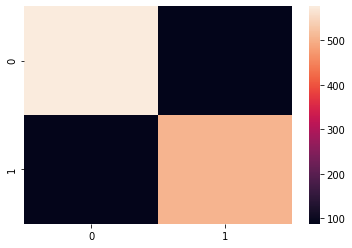

In [151]:
evalua_sklearn(y_true,y_pred,'Glove6B300BiLSTM')

Creemos que la evaluación de este modelo no es tan bueno como se creía que sería. Sin embargo, viendo otros intentos hemos podido notar que mejora de manera considerable cuando se le da un valor más algo de _epochs_.